https://image.slidesharecdn.com/random-170910154045/95/-49-638.jpg?cb=1505089848

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [4]:
network = TwoLayerNet(...)
optimizer = SGD()

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...)  # 미니배치
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...

NameError: name 'TwoLayerNet' is not defined

In [5]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

In [6]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [ ]:
# updates.py

"""
Functions to generate Theano update dictionaries for training.

The update functions implement different methods to control the learning
rate for use with stochastic gradient descent.

Update functions take a loss expression or a list of gradient expressions and
a list of parameters as input and return an ordered dictionary of updates:

.. autosummary::
    :nosignatures:

    sgd
    momentum
    nesterov_momentum
    adagrad
    rmsprop
    adadelta
    adam
    adamax
    amsgrad

Two functions can be used to further modify the updates to include momentum:

.. autosummary::
    :nosignatures:

    apply_momentum
    apply_nesterov_momentum

Finally, we provide two helper functions to constrain the norm of tensors:

.. autosummary::
    :nosignatures:

    norm_constraint
    total_norm_constraint

:func:`norm_constraint()` can be used to constrain the norm of parameters
(as an alternative to weight decay), or for a form of gradient clipping.
:func:`total_norm_constraint()` constrain the total norm of a list of tensors.
This is often used when training recurrent neural networks.

Examples
--------
Using :func:`nesterov_momentum` to define an update dictionary for a toy
example network:

>>> import lasagne
>>> import theano.tensor as T
>>> import theano
>>> from lasagne.nonlinearities import softmax
>>> from lasagne.layers import InputLayer, DenseLayer, get_output
>>> from lasagne.updates import nesterov_momentum
>>> l_in = InputLayer((100, 20))
>>> l1 = DenseLayer(l_in, num_units=3, nonlinearity=softmax)
>>> x = T.matrix('x')  # shp: num_batch x num_features
>>> y = T.ivector('y') # shp: num_batch
>>> l_out = get_output(l1, x)
>>> params = lasagne.layers.get_all_params(l1)
>>> loss = T.mean(T.nnet.categorical_crossentropy(l_out, y))
>>> updates = nesterov_momentum(loss, params, learning_rate=1e-4, momentum=.9)
>>> train_fn = theano.function([x, y], updates=updates)

With :func:`apply_momentum` and :func:`apply_nesterov_momentum`, we can add
momentum to optimization schemes that do not usually support this:

>>> updates = lasagne.updates.rmsprop(loss, params, learning_rate=0.0001)
>>> updates = lasagne.updates.apply_momentum(updates, params, momentum=0.9)

All optimization schemes support symbolic variables for their hyperparameters,
such as shared variables. This allows to vary hyperparameters during training
without recompiling the training function. Note that the dtypes must match the
dtypes of the network parameters, which follow Theano's ``floatX`` setting.
In the following example, we use :func:`lasagne.utils.floatX` to ensure this:

>>> eta = theano.shared(lasagne.utils.floatX(0.001))
>>> updates = lasagne.updates.adam(loss, params, learning_rate=eta)
>>> train_fn = theano.function([x, y], updates=updates)
>>> # we can now modify the learning rate at any time during training:
>>> eta.set_value(lasagne.utils.floatX(eta.get_value() * 0.1))
"""

from collections import OrderedDict

import numpy as np

import theano
import theano.tensor as T
from . import utils

__all__ = [
    "sgd",
    "apply_momentum",
    "momentum",
    "apply_nesterov_momentum",
    "nesterov_momentum",
    "adagrad",
    "rmsprop",
    "adadelta",
    "adam",
    "adamax",
    "amsgrad",
    "norm_constraint",
    "total_norm_constraint"
]


def get_or_compute_grads(loss_or_grads, params):
    """Helper function returning a list of gradients

    Parameters
    ----------
    loss_or_grads : symbolic expression or list of expressions
        A scalar loss expression, or a list of gradient expressions
    params : list of shared variables
        The variables to return the gradients for

    Returns
    -------
    list of expressions
        If `loss_or_grads` is a list, it is assumed to be a list of
        gradients and returned as is, unless it does not match the length
        of `params`, in which case a `ValueError` is raised.
        Otherwise, `loss_or_grads` is assumed to be a cost expression and
        the function returns `theano.grad(loss_or_grads, params)`.

    Raises
    ------
    ValueError
        If `loss_or_grads` is a list of a different length than `params`, or if
        any element of `params` is not a shared variable (while we could still
        compute its gradient, we can never update it and want to fail early).
    """
    if any(not isinstance(p, theano.compile.SharedVariable) for p in params):
        raise ValueError("params must contain shared variables only. If it "
                         "contains arbitrary parameter expressions, then "
                         "lasagne.utils.collect_shared_vars() may help you.")
    if isinstance(loss_or_grads, list):
        if not len(loss_or_grads) == len(params):
            raise ValueError("Got %d gradient expressions for %d parameters" %
                             (len(loss_or_grads), len(params)))
        return loss_or_grads
    else:
        return theano.grad(loss_or_grads, params)


def sgd(loss_or_grads, params, learning_rate):
    """Stochastic Gradient Descent (SGD) updates

    Generates update expressions of the form:

    * ``param := param - learning_rate * gradient``

    Parameters
    ----------
    loss_or_grads : symbolic expression or list of expressions
        A scalar loss expression, or a list of gradient expressions
    params : list of shared variables
        The variables to generate update expressions for
    learning_rate : float or symbolic scalar
        The learning rate controlling the size of update steps

    Returns
    -------
    OrderedDict
        A dictionary mapping each parameter to its update expression
    """
    grads = get_or_compute_grads(loss_or_grads, params)
    updates = OrderedDict()

    for param, grad in zip(params, grads):
        updates[param] = param - learning_rate * grad

    return updates


def apply_momentum(updates, params=None, momentum=0.9):
    """Returns a modified update dictionary including momentum

    Generates update expressions of the form:

    * ``velocity := momentum * velocity + updates[param] - param``
    * ``param := param + velocity``

    Parameters
    ----------
    updates : OrderedDict
        A dictionary mapping parameters to update expressions
    params : iterable of shared variables, optional
        The variables to apply momentum to. If omitted, will apply
        momentum to all `updates.keys()`.
    momentum : float or symbolic scalar, optional
        The amount of momentum to apply. Higher momentum results in
        smoothing over more update steps. Defaults to 0.9.

    Returns
    -------
    OrderedDict
        A copy of `updates` with momentum updates for all `params`.

    Notes
    -----
    Higher momentum also results in larger update steps. To counter that,
    you can optionally scale your learning rate by `1 - momentum`.

    See Also
    --------
    momentum : Shortcut applying momentum to SGD updates
    """
    if params is None:
        params = updates.keys()
    updates = OrderedDict(updates)

    for param in params:
        value = param.get_value(borrow=True)
        velocity = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                                 broadcastable=param.broadcastable)
        x = momentum * velocity + updates[param]
        updates[velocity] = x - param
        updates[param] = x

    return updates


def momentum(loss_or_grads, params, learning_rate, momentum=0.9):
    """Stochastic Gradient Descent (SGD) updates with momentum

    Generates update expressions of the form:

    * ``velocity := momentum * velocity - learning_rate * gradient``
    * ``param := param + velocity``

    Parameters
    ----------
    loss_or_grads : symbolic expression or list of expressions
        A scalar loss expression, or a list of gradient expressions
    params : list of shared variables
        The variables to generate update expressions for
    learning_rate : float or symbolic scalar
        The learning rate controlling the size of update steps
    momentum : float or symbolic scalar, optional
        The amount of momentum to apply. Higher momentum results in
        smoothing over more update steps. Defaults to 0.9.

    Returns
    -------
    OrderedDict
        A dictionary mapping each parameter to its update expression

    Notes
    -----
    Higher momentum also results in larger update steps. To counter that,
    you can optionally scale your learning rate by `1 - momentum`.

    See Also
    --------
    apply_momentum : Generic function applying momentum to updates
    nesterov_momentum : Nesterov's variant of SGD with momentum
    """
    updates = sgd(loss_or_grads, params, learning_rate)
    return apply_momentum(updates, momentum=momentum)


def apply_nesterov_momentum(updates, params=None, momentum=0.9):
    """Returns a modified update dictionary including Nesterov momentum

    Generates update expressions of the form:

    * ``velocity := momentum * velocity + updates[param] - param``
    * ``param := param + momentum * velocity + updates[param] - param``

    Parameters
    ----------
    updates : OrderedDict
        A dictionary mapping parameters to update expressions
    params : iterable of shared variables, optional
        The variables to apply momentum to. If omitted, will apply
        momentum to all `updates.keys()`.
    momentum : float or symbolic scalar, optional
        The amount of momentum to apply. Higher momentum results in
        smoothing over more update steps. Defaults to 0.9.

    Returns
    -------
    OrderedDict
        A copy of `updates` with momentum updates for all `params`.

    Notes
    -----
    Higher momentum also results in larger update steps. To counter that,
    you can optionally scale your learning rate by `1 - momentum`.

    The classic formulation of Nesterov momentum (or Nesterov accelerated
    gradient) requires the gradient to be evaluated at the predicted next
    position in parameter space. Here, we use the formulation described at
    https://github.com/lisa-lab/pylearn2/pull/136#issuecomment-10381617,
    which allows the gradient to be evaluated at the current parameters.

    See Also
    --------
    nesterov_momentum : Shortcut applying Nesterov momentum to SGD updates
    """
    if params is None:
        params = updates.keys()
    updates = OrderedDict(updates)

    for param in params:
        value = param.get_value(borrow=True)
        velocity = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                                 broadcastable=param.broadcastable)
        x = momentum * velocity + updates[param] - param
        updates[velocity] = x
        updates[param] = momentum * x + updates[param]

    return updates


def nesterov_momentum(loss_or_grads, params, learning_rate, momentum=0.9):
    """Stochastic Gradient Descent (SGD) updates with Nesterov momentum

    Generates update expressions of the form:

    * ``velocity := momentum * velocity - learning_rate * gradient``
    * ``param := param + momentum * velocity - learning_rate * gradient``

    Parameters
    ----------
    loss_or_grads : symbolic expression or list of expressions
        A scalar loss expression, or a list of gradient expressions
    params : list of shared variables
        The variables to generate update expressions for
    learning_rate : float or symbolic scalar
        The learning rate controlling the size of update steps
    momentum : float or symbolic scalar, optional
        The amount of momentum to apply. Higher momentum results in
        smoothing over more update steps. Defaults to 0.9.

    Returns
    -------
    OrderedDict
        A dictionary mapping each parameter to its update expression

    Notes
    -----
    Higher momentum also results in larger update steps. To counter that,
    you can optionally scale your learning rate by `1 - momentum`.

    The classic formulation of Nesterov momentum (or Nesterov accelerated
    gradient) requires the gradient to be evaluated at the predicted next
    position in parameter space. Here, we use the formulation described at
    https://github.com/lisa-lab/pylearn2/pull/136#issuecomment-10381617,
    which allows the gradient to be evaluated at the current parameters.

    See Also
    --------
    apply_nesterov_momentum : Function applying momentum to updates
    """
    updates = sgd(loss_or_grads, params, learning_rate)
    return apply_nesterov_momentum(updates, momentum=momentum)


def adagrad(loss_or_grads, params, learning_rate=1.0, epsilon=1e-6):
    """Adagrad updates

    Scale learning rates by dividing with the square root of accumulated
    squared gradients. See [1]_ for further description.

    Parameters
    ----------
    loss_or_grads : symbolic expression or list of expressions
        A scalar loss expression, or a list of gradient expressions
    params : list of shared variables
        The variables to generate update expressions for
    learning_rate : float or symbolic scalar
        The learning rate controlling the size of update steps
    epsilon : float or symbolic scalar
        Small value added for numerical stability

    Returns
    -------
    OrderedDict
        A dictionary mapping each parameter to its update expression

    Notes
    -----
    Using step size eta Adagrad calculates the learning rate for feature i at
    time step t as:

    .. math:: \\eta_{t,i} = \\frac{\\eta}
       {\\sqrt{\\sum^t_{t^\\prime} g^2_{t^\\prime,i}+\\epsilon}} g_{t,i}

    as such the learning rate is monotonically decreasing.

    Epsilon is not included in the typical formula, see [2]_.

    References
    ----------
    .. [1] Duchi, J., Hazan, E., & Singer, Y. (2011):
           Adaptive subgradient methods for online learning and stochastic
           optimization. JMLR, 12:2121-2159.

    .. [2] Chris Dyer:
           Notes on AdaGrad. http://www.ark.cs.cmu.edu/cdyer/adagrad.pdf
    """

    grads = get_or_compute_grads(loss_or_grads, params)
    updates = OrderedDict()

    for param, grad in zip(params, grads):
        value = param.get_value(borrow=True)
        accu = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                             broadcastable=param.broadcastable)
        accu_new = accu + grad ** 2
        updates[accu] = accu_new
        updates[param] = param - (learning_rate * grad /
                                  T.sqrt(accu_new + epsilon))

    return updates


def rmsprop(loss_or_grads, params, learning_rate=1.0, rho=0.9, epsilon=1e-6):
    """RMSProp updates

    Scale learning rates by dividing with the moving average of the root mean
    squared (RMS) gradients. See [1]_ for further description.

    Parameters
    ----------
    loss_or_grads : symbolic expression or list of expressions
        A scalar loss expression, or a list of gradient expressions
    params : list of shared variables
        The variables to generate update expressions for
    learning_rate : float or symbolic scalar
        The learning rate controlling the size of update steps
    rho : float or symbolic scalar
        Gradient moving average decay factor
    epsilon : float or symbolic scalar
        Small value added for numerical stability

    Returns
    -------
    OrderedDict
        A dictionary mapping each parameter to its update expression

    Notes
    -----
    `rho` should be between 0 and 1. A value of `rho` close to 1 will decay the
    moving average slowly and a value close to 0 will decay the moving average
    fast.

    Using the step size :math:`\\eta` and a decay factor :math:`\\rho` the
    learning rate :math:`\\eta_t` is calculated as:

    .. math::
       r_t &= \\rho r_{t-1} + (1-\\rho)*g^2\\\\
       \\eta_t &= \\frac{\\eta}{\\sqrt{r_t + \\epsilon}}

    References
    ----------
    .. [1] Tieleman, T. and Hinton, G. (2012):
           Neural Networks for Machine Learning, Lecture 6.5 - rmsprop.
           Coursera. http://www.youtube.com/watch?v=O3sxAc4hxZU (formula @5:20)
    """
    grads = get_or_compute_grads(loss_or_grads, params)
    updates = OrderedDict()

    # Using theano constant to prevent upcasting of float32
    one = T.constant(1)

    for param, grad in zip(params, grads):
        value = param.get_value(borrow=True)
        accu = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                             broadcastable=param.broadcastable)
        accu_new = rho * accu + (one - rho) * grad ** 2
        updates[accu] = accu_new
        updates[param] = param - (learning_rate * grad /
                                  T.sqrt(accu_new + epsilon))

    return updates


def adadelta(loss_or_grads, params, learning_rate=1.0, rho=0.95, epsilon=1e-6):
    """ Adadelta updates

    Scale learning rates by the ratio of accumulated gradients to accumulated
    updates, see [1]_ and notes for further description.

    Parameters
    ----------
    loss_or_grads : symbolic expression or list of expressions
        A scalar loss expression, or a list of gradient expressions
    params : list of shared variables
        The variables to generate update expressions for
    learning_rate : float or symbolic scalar
        The learning rate controlling the size of update steps
    rho : float or symbolic scalar
        Squared gradient moving average decay factor
    epsilon : float or symbolic scalar
        Small value added for numerical stability

    Returns
    -------
    OrderedDict
        A dictionary mapping each parameter to its update expression

    Notes
    -----
    rho should be between 0 and 1. A value of rho close to 1 will decay the
    moving average slowly and a value close to 0 will decay the moving average
    fast.

    rho = 0.95 and epsilon=1e-6 are suggested in the paper and reported to
    work for multiple datasets (MNIST, speech).

    In the paper, no learning rate is considered (so learning_rate=1.0).
    Probably best to keep it at this value.
    epsilon is important for the very first update (so the numerator does
    not become 0).

    Using the step size eta and a decay factor rho the learning rate is
    calculated as:

    .. math::
       r_t &= \\rho r_{t-1} + (1-\\rho)*g^2\\\\
       \\eta_t &= \\eta \\frac{\\sqrt{s_{t-1} + \\epsilon}}
                             {\sqrt{r_t + \epsilon}}\\\\
       s_t &= \\rho s_{t-1} + (1-\\rho)*(\\eta_t*g)^2

    References
    ----------
    .. [1] Zeiler, M. D. (2012):
           ADADELTA: An Adaptive Learning Rate Method.
           arXiv Preprint arXiv:1212.5701.
    """
    grads = get_or_compute_grads(loss_or_grads, params)
    updates = OrderedDict()

    # Using theano constant to prevent upcasting of float32
    one = T.constant(1)

    for param, grad in zip(params, grads):
        value = param.get_value(borrow=True)
        # accu: accumulate gradient magnitudes
        accu = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                             broadcastable=param.broadcastable)
        # delta_accu: accumulate update magnitudes (recursively!)
        delta_accu = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                                   broadcastable=param.broadcastable)

        # update accu (as in rmsprop)
        accu_new = rho * accu + (one - rho) * grad ** 2
        updates[accu] = accu_new

        # compute parameter update, using the 'old' delta_accu
        update = (grad * T.sqrt(delta_accu + epsilon) /
                  T.sqrt(accu_new + epsilon))
        updates[param] = param - learning_rate * update

        # update delta_accu (as accu, but accumulating updates)
        delta_accu_new = rho * delta_accu + (one - rho) * update ** 2
        updates[delta_accu] = delta_accu_new

    return updates


def adam(loss_or_grads, params, learning_rate=0.001, beta1=0.9,
         beta2=0.999, epsilon=1e-8):
    """Adam updates

    Adam updates implemented as in [1]_.

    Parameters
    ----------
    loss_or_grads : symbolic expression or list of expressions
        A scalar loss expression, or a list of gradient expressions
    params : list of shared variables
        The variables to generate update expressions for
    learning_rate : float or symbolic scalar
        Learning rate
    beta1 : float or symbolic scalar
        Exponential decay rate for the first moment estimates.
    beta2 : float or symbolic scalar
        Exponential decay rate for the second moment estimates.
    epsilon : float or symbolic scalar
        Constant for numerical stability.

    Returns
    -------
    OrderedDict
        A dictionary mapping each parameter to its update expression

    Notes
    -----
    The paper [1]_ includes an additional hyperparameter lambda. This is only
    needed to prove convergence of the algorithm and has no practical use
    (personal communication with the authors), it is therefore omitted here.

    References
    ----------
    .. [1] Kingma, Diederik, and Jimmy Ba (2014):
           Adam: A Method for Stochastic Optimization.
           arXiv preprint arXiv:1412.6980.
    """
    all_grads = get_or_compute_grads(loss_or_grads, params)
    t_prev = theano.shared(utils.floatX(0.))
    updates = OrderedDict()

    # Using theano constant to prevent upcasting of float32
    one = T.constant(1)

    t = t_prev + 1
    a_t = learning_rate*T.sqrt(one-beta2**t)/(one-beta1**t)

    for param, g_t in zip(params, all_grads):
        value = param.get_value(borrow=True)
        m_prev = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                               broadcastable=param.broadcastable)
        v_prev = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                               broadcastable=param.broadcastable)

        m_t = beta1*m_prev + (one-beta1)*g_t
        v_t = beta2*v_prev + (one-beta2)*g_t**2
        step = a_t*m_t/(T.sqrt(v_t) + epsilon)

        updates[m_prev] = m_t
        updates[v_prev] = v_t
        updates[param] = param - step

    updates[t_prev] = t
    return updates


def adamax(loss_or_grads, params, learning_rate=0.002, beta1=0.9,
           beta2=0.999, epsilon=1e-8):
    """Adamax updates

    Adamax updates implemented as in [1]_. This is a variant of of the Adam
    algorithm based on the infinity norm.

    Parameters
    ----------
    loss_or_grads : symbolic expression or list of expressions
        A scalar loss expression, or a list of gradient expressions
    params : list of shared variables
        The variables to generate update expressions for
    learning_rate : float or symbolic scalar
        Learning rate
    beta1 : float or symbolic scalar
        Exponential decay rate for the first moment estimates.
    beta2 : float or symbolic scalar
        Exponential decay rate for the weighted infinity norm estimates.
    epsilon : float or symbolic scalar
        Constant for numerical stability.

    Returns
    -------
    OrderedDict
        A dictionary mapping each parameter to its update expression

    References
    ----------
    .. [1] Kingma, Diederik, and Jimmy Ba (2014):
           Adam: A Method for Stochastic Optimization.
           arXiv preprint arXiv:1412.6980.
    """
    all_grads = get_or_compute_grads(loss_or_grads, params)
    t_prev = theano.shared(utils.floatX(0.))
    updates = OrderedDict()

    # Using theano constant to prevent upcasting of float32
    one = T.constant(1)

    t = t_prev + 1
    a_t = learning_rate/(one-beta1**t)

    for param, g_t in zip(params, all_grads):
        value = param.get_value(borrow=True)
        m_prev = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                               broadcastable=param.broadcastable)
        u_prev = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                               broadcastable=param.broadcastable)

        m_t = beta1*m_prev + (one-beta1)*g_t
        u_t = T.maximum(beta2*u_prev, abs(g_t))
        step = a_t*m_t/(u_t + epsilon)

        updates[m_prev] = m_t
        updates[u_prev] = u_t
        updates[param] = param - step

    updates[t_prev] = t
    return updates


def amsgrad(loss_or_grads, params, learning_rate=0.001, beta1=0.9,
            beta2=0.999, epsilon=1e-8):
    """AMSGrad updates

    AMSGrad updates implemented as in [1]_.

    Parameters
    ----------
    loss_or_grads : symbolic expression or list of expressions
        A scalar loss expression, or a list of gradient expressions
    params : list of shared variables
        The variables to generate update expressions for
    learning_rate : float or symbolic scalar
        Learning rate
    beta1 : float or symbolic scalar
        Exponential decay rate for the first moment estimates.
    beta2 : float or symbolic scalar
        Exponential decay rate for the second moment estimates.
    epsilon : float or symbolic scalar
        Constant for numerical stability.

    Returns
    -------
    OrderedDict
        A dictionary mapping each parameter to its update expression

    References
    ----------
    .. [1] https://openreview.net/forum?id=ryQu7f-RZ
    """
    all_grads = get_or_compute_grads(loss_or_grads, params)
    t_prev = theano.shared(utils.floatX(0.))
    updates = OrderedDict()

    # Using theano constant to prevent upcasting of float32
    one = T.constant(1)

    t = t_prev + 1
    a_t = learning_rate*T.sqrt(one-beta2**t)/(one-beta1**t)

    for param, g_t in zip(params, all_grads):
        value = param.get_value(borrow=True)
        m_prev = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                               broadcastable=param.broadcastable)
        v_prev = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                               broadcastable=param.broadcastable)
        v_hat_prev = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                                   broadcastable=param.broadcastable)

        m_t = beta1*m_prev + (one-beta1)*g_t
        v_t = beta2*v_prev + (one-beta2)*g_t**2
        v_hat_t = T.maximum(v_hat_prev, v_t)
        step = a_t*m_t/(T.sqrt(v_hat_t) + epsilon)

        updates[m_prev] = m_t
        updates[v_prev] = v_t
        updates[v_hat_prev] = v_hat_t
        updates[param] = param - step

    updates[t_prev] = t
    return updates


def norm_constraint(tensor_var, max_norm, norm_axes=None, epsilon=1e-7):
    """Max weight norm constraints and gradient clipping

    This takes a TensorVariable and rescales it so that incoming weight
    norms are below a specified constraint value. Vectors violating the
    constraint are rescaled so that they are within the allowed range.

    Parameters
    ----------
    tensor_var : TensorVariable
        Theano expression for update, gradient, or other quantity.
    max_norm : scalar
        This value sets the maximum allowed value of any norm in
        `tensor_var`.
    norm_axes : sequence (list or tuple)
        The axes over which to compute the norm.  This overrides the
        default norm axes defined for the number of dimensions
        in `tensor_var`. When this is not specified and `tensor_var` is a
        matrix (2D), this is set to `(0,)`. If `tensor_var` is a 3D, 4D or
        5D tensor, it is set to a tuple listing all axes but axis 0. The
        former default is useful for working with dense layers, the latter
        is useful for 1D, 2D and 3D convolutional layers.
        (Optional)
    epsilon : scalar, optional
        Value used to prevent numerical instability when dividing by
        very small or zero norms.

    Returns
    -------
    TensorVariable
        Input `tensor_var` with rescaling applied to weight vectors
        that violate the specified constraints.

    Examples
    --------
    >>> param = theano.shared(
    ...     np.random.randn(100, 200).astype(theano.config.floatX))
    >>> update = param + 100
    >>> update = norm_constraint(update, 10)
    >>> func = theano.function([], [], updates=[(param, update)])
    >>> # Apply constrained update
    >>> _ = func()
    >>> from lasagne.utils import compute_norms
    >>> norms = compute_norms(param.get_value())
    >>> np.isclose(np.max(norms), 10)
    True

    Notes
    -----
    When `norm_axes` is not specified, the axes over which the norm is
    computed depend on the dimensionality of the input variable. If it is
    2D, it is assumed to come from a dense layer, and the norm is computed
    over axis 0. If it is 3D, 4D or 5D, it is assumed to come from a
    convolutional layer and the norm is computed over all trailing axes
    beyond axis 0. For other uses, you should explicitly specify the axes
    over which to compute the norm using `norm_axes`.
    """
    ndim = tensor_var.ndim

    if norm_axes is not None:
        sum_over = tuple(norm_axes)
    elif ndim == 2:  # DenseLayer
        sum_over = (0,)
    elif ndim in [3, 4, 5]:  # Conv{1,2,3}DLayer
        sum_over = tuple(range(1, ndim))
    else:
        raise ValueError(
            "Unsupported tensor dimensionality {}."
            "Must specify `norm_axes`".format(ndim)
        )

    dtype = np.dtype(theano.config.floatX).type
    norms = T.sqrt(T.sum(T.sqr(tensor_var), axis=sum_over, keepdims=True))
    target_norms = T.clip(norms, 0, dtype(max_norm))
    constrained_output = \
        (tensor_var * (target_norms / (dtype(epsilon) + norms)))

    return constrained_output


def total_norm_constraint(tensor_vars, max_norm, epsilon=1e-7,
                          return_norm=False):
    """Rescales a list of tensors based on their combined norm

    If the combined norm of the input tensors exceeds the threshold then all
    tensors are rescaled such that the combined norm is equal to the threshold.

    Scaling the norms of the gradients is often used when training recurrent
    neural networks [1]_.

    Parameters
    ----------
    tensor_vars : List of TensorVariables.
        Tensors to be rescaled.
    max_norm : float
        Threshold value for total norm.
    epsilon : scalar, optional
        Value used to prevent numerical instability when dividing by
        very small or zero norms.
    return_norm : bool
        If true the total norm is also returned.

    Returns
    -------
    tensor_vars_scaled : list of TensorVariables
        The scaled tensor variables.
    norm : Theano scalar
        The combined norms of the input variables prior to rescaling,
        only returned if ``return_norms=True``.

    Examples
    --------
    >>> from lasagne.layers import InputLayer, DenseLayer
    >>> import lasagne
    >>> from lasagne.updates import sgd, total_norm_constraint
    >>> x = T.matrix()
    >>> y = T.ivector()
    >>> l_in = InputLayer((5, 10))
    >>> l1 = DenseLayer(l_in, num_units=7, nonlinearity=T.nnet.softmax)
    >>> output = lasagne.layers.get_output(l1, x)
    >>> cost = T.mean(T.nnet.categorical_crossentropy(output, y))
    >>> all_params = lasagne.layers.get_all_params(l1)
    >>> all_grads = T.grad(cost, all_params)
    >>> scaled_grads = total_norm_constraint(all_grads, 5)
    >>> updates = sgd(scaled_grads, all_params, learning_rate=0.1)

    Notes
    -----
    The total norm can be used to monitor training.

    References
    ----------
    .. [1] Sutskever, I., Vinyals, O., & Le, Q. V. (2014): Sequence to sequence
       learning with neural networks. In Advances in Neural Information
       Processing Systems (pp. 3104-3112).
    """
    norm = T.sqrt(sum(T.sum(tensor**2) for tensor in tensor_vars))
    dtype = np.dtype(theano.config.floatX).type
    target_norm = T.clip(norm, 0, dtype(max_norm))
    multiplier = target_norm / (dtype(epsilon) + norm)
    tensor_vars_scaled = [step*multiplier for step in tensor_vars]

    if return_norm:
        return tensor_vars_scaled, norm
    else:
        return tensor_vars_scaled

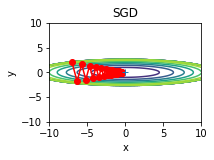

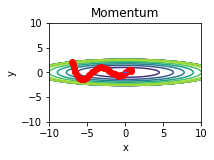

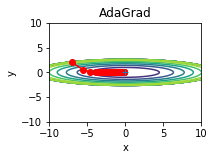

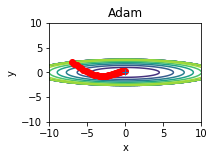

In [78]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from src.common.optimizer import *

def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
        
    
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y ,Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    # colorbar()
    # spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.show()

==========iteration:0==========
SGD:2.294513668425685
Momentum:2.4236631917026026
AdaGrad:1.951247055972694
Adam:2.2619770227494698
==========iteration:100==========
SGD:1.329098460538757
Momentum:0.3186781143581999
AdaGrad:0.15200554774400954
Adam:0.22883040862126686
==========iteration:200==========
SGD:0.6853911910277787
Momentum:0.26702470897404057
AdaGrad:0.11151990206073004
Adam:0.22650500663893458
==========iteration:300==========
SGD:0.5476250563260259
Momentum:0.2055268521719118
AdaGrad:0.10621696122469781
Adam:0.17219691209854268
==========iteration:400==========
SGD:0.3231680239763236
Momentum:0.1382813754779741
AdaGrad:0.034609343310991345
Adam:0.0791280063067189
==========iteration:500==========
SGD:0.41468580860754634
Momentum:0.1487521623665899
AdaGrad:0.07080674630959063
Adam:0.1498046779637045
==========iteration:600==========
SGD:0.3979113200598791
Momentum:0.19930384466401493
AdaGrad:0.04850187368017229
Adam:0.1062299918575284
==========iteration:700==========
SGD:0.

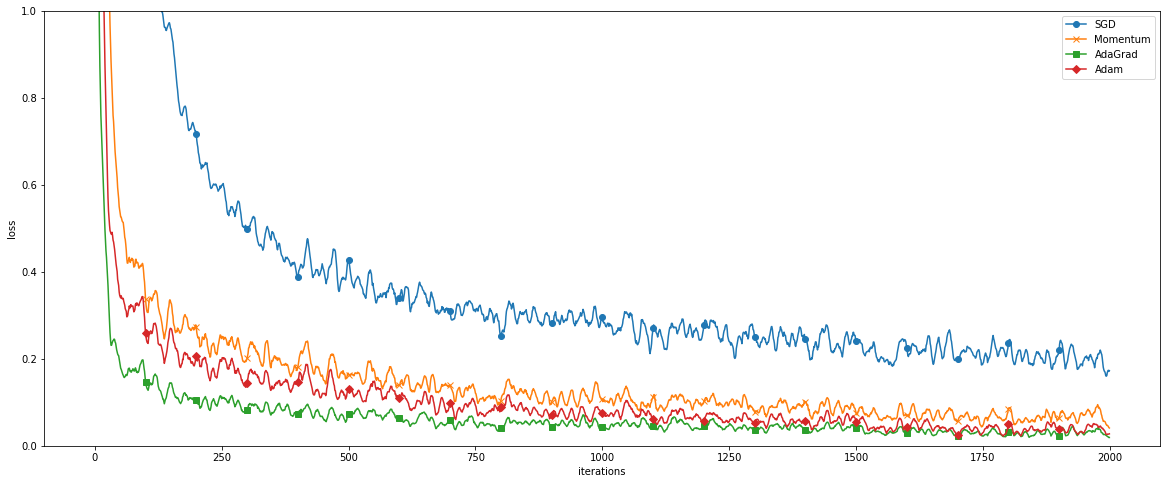

In [73]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정

from src.dataset.mnist import load_mnist
from src.common.util import smooth_curve
from src.common.multi_layer_net import MultiLayerNet
from src.common.optimizer import *
import matplotlib.pyplot as plt

# 0. mnist 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1. 실험용 설정
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
# optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []
    
# 2. 훈련 시작
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    if i % 100 == 0:
        print( "==========" + "iteration:" + str(i) + "==========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))
            
# 3. 그래프 그리기
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
plt.figure(figsize=(20,8))
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 6.2 가중치의 초깃값

### 6.2.1 초깃값을 0으로 하면?


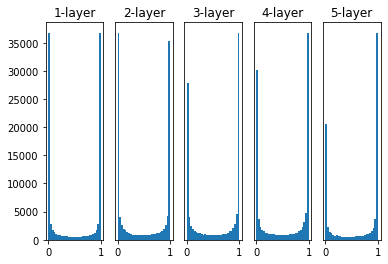

In [79]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)
    
def tanh(x):
    return np.tanh(x)


x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 이 곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 가중치 표준편차가 1인 정규분포로 초기화
    w = np.random.randn(node_num, node_num) * 1
    
    a = np.dot(x, w)


    # 활성화함수 : sigmoid
    z = sigmoid(a)
    
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


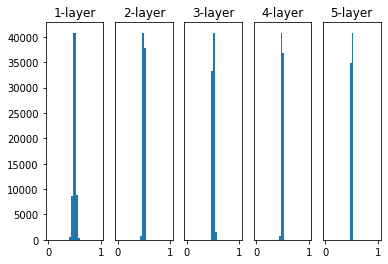

In [80]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 이 곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 가중치 표준편차가 0.01인 정규분포로 초기화
    w = np.random.randn(node_num, node_num) * 0.01
    
    a = np.dot(x, w)


    # 활성화함수 : sigmoid
    z = sigmoid(a)
    
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


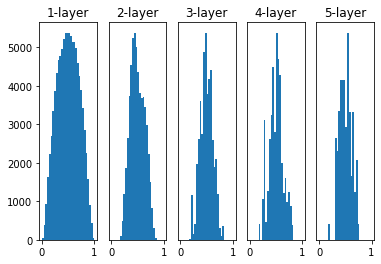

In [85]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 이 곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 가중치 초깃값이 Xavier
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    
    a = np.dot(x, w)


    # 활성화함수 : sigmoid
    z = sigmoid(a)
    
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


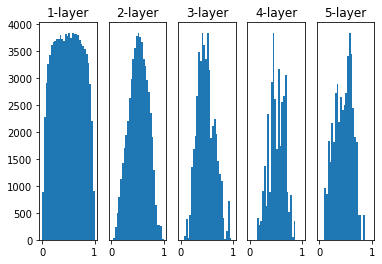

In [86]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 이 곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 가중치 초깃값이 He
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    
    a = np.dot(x, w)


    # 활성화함수 : sigmoid
    z = sigmoid(a)
    
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


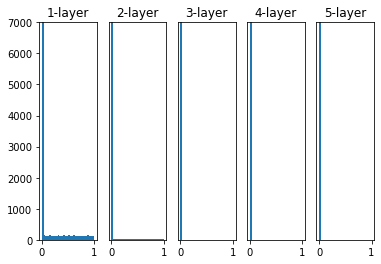

In [56]:
# 6.2.3 ReLU를 사용할 때의 가중치 초깃값

x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 이 곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 가중치 표준편차가 1인 정규분포로 초기화
    w = np.random.randn(node_num, node_num) * 1
    
    a = np.dot(x, w)


    # 활성화함수 : ReLU
    z = ReLU(a)
    
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


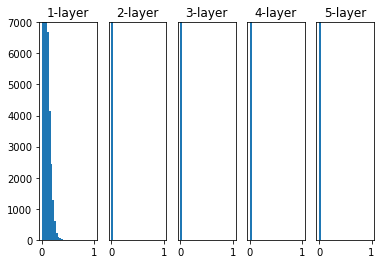

In [57]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 이 곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 가중치 표준편차가 0.01인 정규분포로 초기화
    w = np.random.randn(node_num, node_num) * 0.01
    
    a = np.dot(x, w)


    # 활성화함수 : ReLU
    z = ReLU(a)
    
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


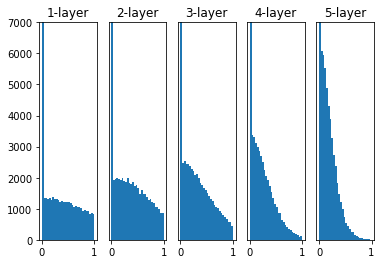

In [87]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 이 곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 가중치 초깃값이 Xavier
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    
    a = np.dot(x, w)


    # 활성화함수 : ReLU
    z = ReLU(a)
    
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


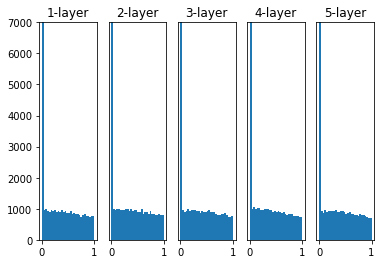

In [88]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 이 곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 가중치 초깃값이 He
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    
    a = np.dot(x, w)


    # 활성화함수 : ReLU
    z = ReLU(a)
    
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


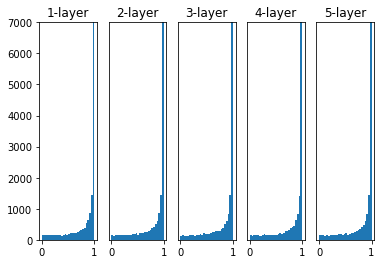

In [93]:
# 6.2.3 tanh을 사용할 때의 가중치 초깃값

x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 이 곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 가중치 표준편차가 1인 정규분포로 초기화
    w = np.random.randn(node_num, node_num) * 1
    
    a = np.dot(x, w)


    # 활성화함수 : tanh
    z = tanh(a)
    
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


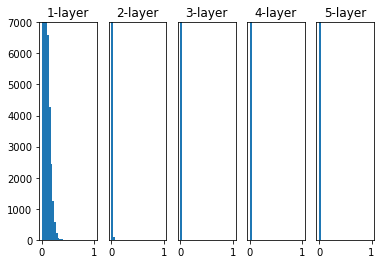

In [91]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 이 곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 가중치 표준편차가 0.01인 정규분포로 초기화
    w = np.random.randn(node_num, node_num) * 0.01
    
    a = np.dot(x, w)


    # 활성화함수 : tanh
    z = tanh(a)
    
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


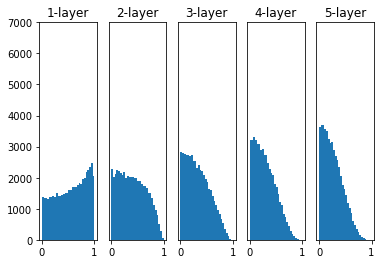

In [94]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 이 곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 가중치 초깃값이 Xavier
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    
    a = np.dot(x, w)


    # 활성화함수 : tanh
    z = tanh(a)
    
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


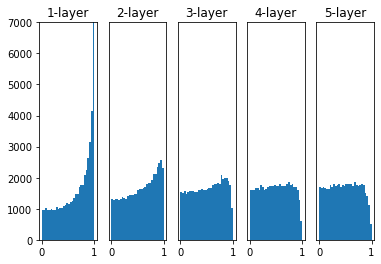

In [95]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 이 곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 가중치 초깃값이 He
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    
    a = np.dot(x, w)


    # 활성화함수 : tanh
    z = tanh(a)
    
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


==========iteration:0==========
std=0.01:2.302444600608641
Xavier:2.3018572549367655
He:2.2911442869185867
==========iteration:100==========
std=0.01:2.301938062861019
Xavier:2.2235645852713324
He:1.5949537200194213
==========iteration:200==========
std=0.01:2.3022040195988107
Xavier:2.1105161607360037
He:0.890468344610916
==========iteration:300==========
std=0.01:2.3032638212386463
Xavier:1.645041773870255
He:0.48035851885200437
==========iteration:400==========
std=0.01:2.3046583503244675
Xavier:1.1285084390652234
He:0.4563875539034422
==========iteration:500==========
std=0.01:2.3031918393224844
Xavier:0.831883092587794
He:0.46731983098064855
==========iteration:600==========
std=0.01:2.3021314686203214
Xavier:0.6621956377681958
He:0.44712960576701044
==========iteration:700==========
std=0.01:2.2960262979690764
Xavier:0.3496331644486365
He:0.18679889526146182
==========iteration:800==========
std=0.01:2.301973520832652
Xavier:0.5417060983501609
He:0.3645156861477389
==========iter

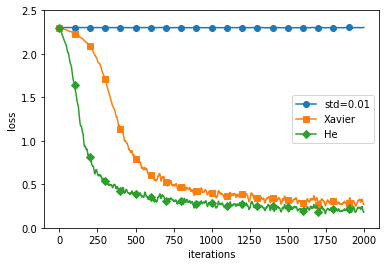

In [99]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정

import numpy as np
import matplotlib.pyplot as plt
from src.dataset.mnist import load_mnist
from src.common.util import smooth_curve
from src.common.multi_layer_net import MultiLayerNet
from src.common.optimizer import *


# 0. mnist 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10, weight_init_std=weight_type)
    train_loss[key] = []
    
    
# 2. 훈련 시작
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    if i % 100 == 0:
        print( "==========" + "iteration:" + str(i) + "==========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))
            
            
# 3. 그래프 그리기
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## 6.3 배치 정규화

      - 가중치의 초깃값을 적절히 설정하면 각 층의 활성화값 분포가 적당히 퍼짐
      - 효율적인 학습이 가능
      - 각층에서 활성화를 적당히 퍼뜨리도록 강제하는 것이 배치 정규화


### 6.3.1 배치 정규화 알고리즘
        
        가. 배치 정규화의 잇점
          - 학습 속도 개선(학습률을 높게 설정할 수 있음)
          - 가중치 초깃값 선택의 의존성이 적어짐(학습을 할 때마다 출력값 정규화)
          - 과적합 위험을 줄임(드롭아웃 필요성 감소 - 대체 가능)
          



============== 1/16 ==============
epoch:0 | 0.094 - 0.111


ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

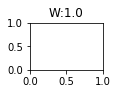

In [123]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from src.dataset.mnist import load_mnist
from src.common.multi_layer_net_extend import MultiLayerNetExtend
from src.common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)


# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
            
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
            
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
            
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
        return train_acc_list, bn_train_acc_list


# 그래프 그리기
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)

    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

In [ ]:


# 그래프 그리기
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print("========== " + str(i+1) + "/16" + " ==========")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)
        
    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
        
    plt.show()

============== 1/16 ==============
epoch:0 | 0.117 - 0.067
epoch:1 | 0.097 - 0.071


../src/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
../src/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
../src/common/layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)


epoch:2 | 0.097 - 0.09
epoch:3 | 0.097 - 0.133
epoch:4 | 0.097 - 0.157
epoch:5 | 0.097 - 0.182
epoch:6 | 0.097 - 0.198
epoch:7 | 0.097 - 0.221
epoch:8 | 0.097 - 0.233
epoch:9 | 0.097 - 0.252
epoch:10 | 0.097 - 0.274
epoch:11 | 0.097 - 0.291
epoch:12 | 0.097 - 0.302
epoch:13 | 0.097 - 0.325
epoch:14 | 0.097 - 0.337
epoch:15 | 0.097 - 0.356
epoch:16 | 0.097 - 0.374


No handles with labels found to put in legend.


epoch:17 | 0.097 - 0.391
epoch:18 | 0.097 - 0.393
epoch:19 | 0.097 - 0.408
============== 2/16 ==============
epoch:0 | 0.087 - 0.088
epoch:1 | 0.097 - 0.111
epoch:2 | 0.097 - 0.14
epoch:3 | 0.097 - 0.186
epoch:4 | 0.097 - 0.23
epoch:5 | 0.097 - 0.265
epoch:6 | 0.097 - 0.293
epoch:7 | 0.097 - 0.312
epoch:8 | 0.097 - 0.337
epoch:9 | 0.097 - 0.354
epoch:10 | 0.097 - 0.379
epoch:11 | 0.097 - 0.399
epoch:12 | 0.097 - 0.417
epoch:13 | 0.097 - 0.439
epoch:14 | 0.097 - 0.455
epoch:15 | 0.097 - 0.474
epoch:16 | 0.097 - 0.491
epoch:17 | 0.097 - 0.511


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.51
epoch:19 | 0.097 - 0.534
============== 3/16 ==============
epoch:0 | 0.179 - 0.105
epoch:1 | 0.387 - 0.112
epoch:2 | 0.517 - 0.149
epoch:3 | 0.619 - 0.201
epoch:4 | 0.687 - 0.246
epoch:5 | 0.742 - 0.281
epoch:6 | 0.78 - 0.311
epoch:7 | 0.839 - 0.34
epoch:8 | 0.847 - 0.374
epoch:9 | 0.887 - 0.402
epoch:10 | 0.911 - 0.425
epoch:11 | 0.918 - 0.451
epoch:12 | 0.93 - 0.47
epoch:13 | 0.941 - 0.508
epoch:14 | 0.956 - 0.518
epoch:15 | 0.961 - 0.543
epoch:16 | 0.96 - 0.564


No handles with labels found to put in legend.


epoch:17 | 0.971 - 0.583
epoch:18 | 0.974 - 0.593
epoch:19 | 0.971 - 0.621
============== 4/16 ==============
epoch:0 | 0.094 - 0.09
epoch:1 | 0.224 - 0.119
epoch:2 | 0.362 - 0.219
epoch:3 | 0.451 - 0.286
epoch:4 | 0.531 - 0.344
epoch:5 | 0.591 - 0.423
epoch:6 | 0.623 - 0.462
epoch:7 | 0.661 - 0.502
epoch:8 | 0.69 - 0.539
epoch:9 | 0.71 - 0.572
epoch:10 | 0.72 - 0.602
epoch:11 | 0.741 - 0.621
epoch:12 | 0.763 - 0.649
epoch:13 | 0.791 - 0.68
epoch:14 | 0.793 - 0.706
epoch:15 | 0.795 - 0.733
epoch:16 | 0.816 - 0.749
epoch:17 | 0.833 - 0.758


No handles with labels found to put in legend.


epoch:18 | 0.839 - 0.779
epoch:19 | 0.847 - 0.798
============== 5/16 ==============
epoch:0 | 0.099 - 0.103
epoch:1 | 0.111 - 0.142
epoch:2 | 0.119 - 0.264
epoch:3 | 0.127 - 0.392
epoch:4 | 0.139 - 0.492
epoch:5 | 0.154 - 0.577
epoch:6 | 0.162 - 0.649
epoch:7 | 0.166 - 0.684
epoch:8 | 0.174 - 0.725
epoch:9 | 0.174 - 0.744
epoch:10 | 0.181 - 0.77
epoch:11 | 0.193 - 0.8
epoch:12 | 0.198 - 0.811
epoch:13 | 0.199 - 0.826
epoch:14 | 0.205 - 0.842
epoch:15 | 0.213 - 0.851
epoch:16 | 0.219 - 0.856
epoch:17 | 0.232 - 0.868
epoch:18 | 0.232 - 0.875


No handles with labels found to put in legend.


epoch:19 | 0.234 - 0.888
============== 6/16 ==============
epoch:0 | 0.134 - 0.083
epoch:1 | 0.182 - 0.159
epoch:2 | 0.131 - 0.446
epoch:3 | 0.126 - 0.615
epoch:4 | 0.144 - 0.69
epoch:5 | 0.184 - 0.734
epoch:6 | 0.129 - 0.765
epoch:7 | 0.18 - 0.801
epoch:8 | 0.19 - 0.826
epoch:9 | 0.163 - 0.841
epoch:10 | 0.136 - 0.851
epoch:11 | 0.145 - 0.867
epoch:12 | 0.117 - 0.883
epoch:13 | 0.167 - 0.895
epoch:14 | 0.203 - 0.902
epoch:15 | 0.179 - 0.922
epoch:16 | 0.15 - 0.936
epoch:17 | 0.117 - 0.943


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.949
epoch:19 | 0.117 - 0.956
============== 7/16 ==============
epoch:0 | 0.132 - 0.155
epoch:1 | 0.116 - 0.347
epoch:2 | 0.116 - 0.57
epoch:3 | 0.117 - 0.672
epoch:4 | 0.117 - 0.736
epoch:5 | 0.157 - 0.815
epoch:6 | 0.117 - 0.841
epoch:7 | 0.117 - 0.873
epoch:8 | 0.117 - 0.898
epoch:9 | 0.117 - 0.921
epoch:10 | 0.117 - 0.934
epoch:11 | 0.117 - 0.954
epoch:12 | 0.117 - 0.964
epoch:13 | 0.117 - 0.971
epoch:14 | 0.117 - 0.977
epoch:15 | 0.117 - 0.981
epoch:16 | 0.117 - 0.985


No handles with labels found to put in legend.


epoch:17 | 0.117 - 0.988
epoch:18 | 0.117 - 0.991
epoch:19 | 0.117 - 0.995
============== 8/16 ==============
epoch:0 | 0.093 - 0.118
epoch:1 | 0.116 - 0.446
epoch:2 | 0.116 - 0.67
epoch:3 | 0.116 - 0.744
epoch:4 | 0.116 - 0.813
epoch:5 | 0.116 - 0.835
epoch:6 | 0.116 - 0.866
epoch:7 | 0.116 - 0.9
epoch:8 | 0.116 - 0.924
epoch:9 | 0.116 - 0.948
epoch:10 | 0.116 - 0.971
epoch:11 | 0.116 - 0.984
epoch:12 | 0.116 - 0.989
epoch:13 | 0.116 - 0.994
epoch:14 | 0.116 - 0.995
epoch:15 | 0.116 - 0.996
epoch:16 | 0.116 - 0.997
epoch:17 | 0.116 - 0.998


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.998
epoch:19 | 0.116 - 0.999
============== 9/16 ==============
epoch:0 | 0.117 - 0.093
epoch:1 | 0.117 - 0.597
epoch:2 | 0.117 - 0.727
epoch:3 | 0.117 - 0.755
epoch:4 | 0.117 - 0.808
epoch:5 | 0.117 - 0.862
epoch:6 | 0.117 - 0.871
epoch:7 | 0.117 - 0.885
epoch:8 | 0.117 - 0.95
epoch:9 | 0.117 - 0.983
epoch:10 | 0.117 - 0.975
epoch:11 | 0.117 - 0.998
epoch:12 | 0.117 - 0.995
epoch:13 | 0.117 - 0.998
epoch:14 | 0.117 - 0.998
epoch:15 | 0.117 - 0.998
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.094 - 0.106
epoch:1 | 0.116 - 0.543
epoch:2 | 0.117 - 0.727
epoch:3 | 0.116 - 0.742
epoch:4 | 0.117 - 0.843
epoch:5 | 0.116 - 0.929
epoch:6 | 0.116 - 0.951
epoch:7 | 0.116 - 0.972
epoch:8 | 0.117 - 0.97
epoch:9 | 0.117 - 0.979
epoch:10 | 0.117 - 0.989
epoch:11 | 0.117 - 0.993
epoch:12 | 0.117 - 0.994
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.997
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.996


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.999
epoch:19 | 0.117 - 0.991
============== 11/16 ==============
epoch:0 | 0.099 - 0.133
epoch:1 | 0.105 - 0.516
epoch:2 | 0.117 - 0.707
epoch:3 | 0.117 - 0.708
epoch:4 | 0.117 - 0.77
epoch:5 | 0.117 - 0.783
epoch:6 | 0.117 - 0.788
epoch:7 | 0.117 - 0.884
epoch:8 | 0.117 - 0.876
epoch:9 | 0.116 - 0.889
epoch:10 | 0.116 - 0.865
epoch:11 | 0.116 - 0.895
epoch:12 | 0.116 - 0.899
epoch:13 | 0.116 - 0.9
epoch:14 | 0.116 - 0.9
epoch:15 | 0.116 - 0.9
epoch:16 | 0.116 - 0.9
epoch:17 | 0.116 - 0.953
epoch:18 | 0.116 - 0.914


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.934
============== 12/16 ==============
epoch:0 | 0.105 - 0.124
epoch:1 | 0.117 - 0.557
epoch:2 | 0.117 - 0.72
epoch:3 | 0.117 - 0.763
epoch:4 | 0.117 - 0.797
epoch:5 | 0.117 - 0.857
epoch:6 | 0.117 - 0.848
epoch:7 | 0.117 - 0.869
epoch:8 | 0.117 - 0.88
epoch:9 | 0.117 - 0.83
epoch:10 | 0.117 - 0.966
epoch:11 | 0.117 - 0.966
epoch:12 | 0.117 - 0.889
epoch:13 | 0.117 - 0.987
epoch:14 | 0.117 - 0.986
epoch:15 | 0.116 - 0.986
epoch:16 | 0.116 - 0.992


No handles with labels found to put in legend.


epoch:17 | 0.116 - 0.993
epoch:18 | 0.116 - 0.994
epoch:19 | 0.116 - 0.995
============== 13/16 ==============
epoch:0 | 0.1 - 0.143
epoch:1 | 0.105 - 0.513
epoch:2 | 0.116 - 0.587
epoch:3 | 0.116 - 0.59
epoch:4 | 0.117 - 0.623
epoch:5 | 0.116 - 0.689
epoch:6 | 0.117 - 0.687
epoch:7 | 0.117 - 0.656
epoch:8 | 0.117 - 0.686
epoch:9 | 0.117 - 0.675
epoch:10 | 0.117 - 0.696
epoch:11 | 0.117 - 0.691
epoch:12 | 0.117 - 0.706
epoch:13 | 0.117 - 0.704
epoch:14 | 0.117 - 0.718
epoch:15 | 0.117 - 0.708
epoch:16 | 0.117 - 0.711
epoch:17 | 0.116 - 0.712


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.713
epoch:19 | 0.117 - 0.805
============== 14/16 ==============
epoch:0 | 0.116 - 0.097
epoch:1 | 0.116 - 0.393
epoch:2 | 0.116 - 0.403
epoch:3 | 0.116 - 0.409
epoch:4 | 0.116 - 0.464
epoch:5 | 0.116 - 0.415
epoch:6 | 0.116 - 0.48
epoch:7 | 0.116 - 0.575
epoch:8 | 0.116 - 0.6
epoch:9 | 0.116 - 0.567
epoch:10 | 0.116 - 0.599
epoch:11 | 0.116 - 0.61
epoch:12 | 0.116 - 0.602
epoch:13 | 0.116 - 0.616
epoch:14 | 0.116 - 0.609
epoch:15 | 0.116 - 0.619
epoch:16 | 0.117 - 0.617
epoch:17 | 0.117 - 0.62


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.586
epoch:19 | 0.117 - 0.618
============== 15/16 ==============
epoch:0 | 0.097 - 0.178
epoch:1 | 0.116 - 0.281
epoch:2 | 0.116 - 0.383
epoch:3 | 0.116 - 0.502
epoch:4 | 0.116 - 0.48
epoch:5 | 0.116 - 0.506
epoch:6 | 0.117 - 0.514
epoch:7 | 0.117 - 0.52
epoch:8 | 0.117 - 0.513
epoch:9 | 0.117 - 0.523
epoch:10 | 0.117 - 0.456
epoch:11 | 0.117 - 0.525
epoch:12 | 0.117 - 0.529
epoch:13 | 0.117 - 0.535
epoch:14 | 0.117 - 0.528
epoch:15 | 0.117 - 0.526
epoch:16 | 0.117 - 0.521
epoch:17 | 0.117 - 0.541
epoch:18 | 0.117 - 0.616


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.611
============== 16/16 ==============
epoch:0 | 0.116 - 0.162
epoch:1 | 0.117 - 0.207
epoch:2 | 0.116 - 0.287
epoch:3 | 0.116 - 0.406
epoch:4 | 0.116 - 0.403
epoch:5 | 0.117 - 0.441
epoch:6 | 0.117 - 0.478
epoch:7 | 0.117 - 0.501
epoch:8 | 0.117 - 0.51
epoch:9 | 0.117 - 0.516
epoch:10 | 0.117 - 0.515
epoch:11 | 0.117 - 0.515
epoch:12 | 0.117 - 0.518
epoch:13 | 0.117 - 0.517
epoch:14 | 0.117 - 0.518
epoch:15 | 0.117 - 0.518
epoch:16 | 0.117 - 0.517
epoch:17 | 0.117 - 0.514
epoch:18 | 0.117 - 0.519
epoch:19 | 0.117 - 0.517


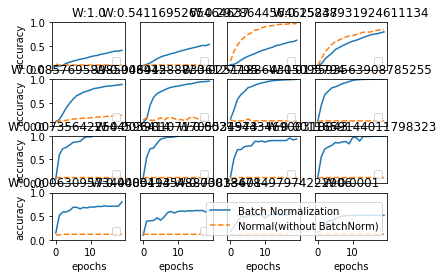

In [105]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from src.dataset.mnist import load_mnist
from src.common.multi_layer_net_extend import MultiLayerNetExtend
from src.common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()